# 4.1 Introduction

Hi guys! I hope your learning is going good. And we are here! at the final chapter of our series. In this chapter we will combine all the informations we had learned from chapter 1 to 3. We will try to create an Image captioning model on COCO data set created by microsoft. 

We will employ our knowledge of multimodal learning from first chapter. Then we will try to extract visual features from the images to identify different object in the images and finally we will use an LSTM to generate text descriptions on test images. So withot wasting the time let's straight jump into the problem itself.

# 4.2 Image Captioning problem

So what do you think; why image captioning could be an important task? Well in robotics it could be quite crucial. It can help machines to not only categorized the images but it can also relate the information with the context in the images. Which altogether create a stronger AI system.

Let's take a look about what we want from our image captioning system.

<img src='1_captions-splash.jpg' width='600'>

So this is what we want. We want to generate relatable description for input image which can tell us what is actually happening in the image. Simple! yup it should be more easier for you now. As we have already seen how we can extract visual information from the images  in chapter 2 and Generate text using LSTM; I think we can do it. What do you say?

*What we will gonna do to solve this problem?* Well as you are already aware about multimodal learning now, it would not be dofficult for me to tell you about how we will solve this problem. Yup we will create a Multimodal learning system similar to the following architecture.

<img src='2_MultimodalArch.png' width='350'>

Yes I know you have already seen this architecture in chapter 2. We will going to do something similar. Information source 1 will be images for us and information source 2 will be text data. We will process both the information using a visual feature extractor and an LSTM respectively.  

So what we can do right now? We can create a model to handle image information, we can create one more model to handle text data; and then we can combine both the information for generate new text on an input image; our framework will use following ingredients;

-	A data set.
-	We will need a visual feature extractor.
-	A textual feature extractor.
-	A model which can handle the combined feature information.

We can think of an architecture which looks like this one:

<img src='3_Merge_Model_for_Image_Captioning.png' width='550'>

*We had already discussed about this architecture in Chapter 2.*

After mixing above ingredient with proper processing, we can create a caption generator.
So what are we waiting for? Well we have just discussed about the ingredient, we have not discussed about the recipe. So let’s talk about it.


## 4.2.1 Data set

We will use Microsoft's [COCO data set](http://cocodataset.org/#download) for our application. COCO is one of the largest labelled image data set. It comes with a handy API to extract different information from the data set. Before proceeding for further discussion about the data set; first you need to download the COCO API from [here](https://github.com/cocodataset/cocoapi). Do remember we need to download Python API for our task (just kidding!!). 

When you will landing on the data set download page you will find year wise labelled data sets for images as well as their annotations. For image captioning task we will use training and validation data set from year 2014. 

You will notice that both the data set (training and val) are very large files. Where training data set is around 13 GB in size validation data is more than 6 GB. for our application I will use validation data set as it takes less time to download and process. You will also need to download the corresponding annotation file for the data set. This file will consist of the image captions arrange by image ids. I will encourage to use training data set for experimentation. 

Once you download the data set add the directory path into your code module. I have kept the data set on my local hard drive. Follwong code snippet will give you an idea about the data. Following code uses COCO API to extract information from the data. So before running the following lines please make sure that API should be in the same folder as your notebook.

In [19]:
import os
import COCO

# initialize COCO API for instance annotations
dataDir = 'C:/Users/DX/Documents/Downloads/Compressed/val2014/annotations_trainval2014/'

# We will use validation data set for model training
dataType = 'val2014'

# Create object for data extraction using API
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO.COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO.COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=9.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!


Looks good! Now as index created now we can visualize an image and its corresponding captions. We will use skimage library to load and visualize the images. Again COCO API will be used for extraction of image information such as image name, image id and captions for the image. There are 5 captions are available for each image id. Some time you may find multiple image ids for the same image. This has done because that image carries information which required more than 5 captions. Information is stored in the form of a python dictionary for each image id. We can extract the image information using dictionary keys. 

Following code snippet will extract this information for us.

{'license': 3, 'file_name': 'COCO_val2014_000000099908.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000099908.jpg', 'height': 400, 'width': 640, 'date_captured': '2013-11-15 12:59:50', 'flickr_url': 'http://farm7.staticflickr.com/6017/5942669935_29913b8129_z.jpg', 'id': 99908}


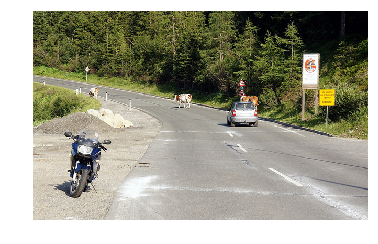

A car stopped by three cows crossing a road.
some cows cross a road as a car passes by 
A car that is sitting near a couple of cows in the street.
A car is heading down the road and there is a cow standing in their pathway. 
a motorcycle parked on the side of the road 


In [20]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

image_path = 'C:/Users/DX/Documents/Downloads/Compressed/val2014/val2014/'

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]

# We get a python dictionary for each image id
print(img)
image_name = img['file_name']

# print URL and visualize corresponding image
# print(url)
I = io.imread(image_path+image_name)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

All looks fine. As you can see there are 5 captions are given for the selected image. Our job is to design a system which can learn image features as well as textual features to generate captions as shown above for any given image.

Now as there are more than 40000 images are present in the data set. We need to create a sample set to save some time in pre-processing of the data and training of the model. For this we will select few images from the data set and their corresponding captions. We will store this information in a text file. We will select the images randomaly.

Following snippet will do the same for us.

In [31]:
# Directory to store selected images and their captions
dir_text = 'D:/GoogleDrive/TechDocuments/Webinars/GrayAtom/Chapter_4_ImageCaptioning/ImageCaptionData/'

# Text file name
annotation_file = 'annotations.txt'
txt_file = dir_text+annotation_file

# Let's create a text file 
file = open(txt_file,'a')

# We will randomaly select some images 
import random
ran_ids = random.sample(range(len(ids)),1000)
ann_id = [ids[sub_ids] for sub_ids in ran_ids]

# Let's write the information into the text file.
for i in range(len(ann_id)):
    img_id = coco.anns[ann_id[i]]['image_id']    
    img = coco.loadImgs(img_id)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)    
    image_name = img['file_name']
    [file.write(image_name+' '+anns[an]['caption']+'\n') for an in range(len(anns))]

file.close()

So our text file is now ready. We will see how to use this file for creating the data set for training our model. But before that we will need to understand our rest of the architecture.

## 4.2.2 Visual Feature extractor

For image feature extraction task we will use a deep convolutional neural network, main reason behind it is; local receptive fields, weight sharing and pooling operations, for more information about these terms please refer chapter 2.

We can get more robust features of an input image using a convolutional neural net (CNN), because it learns features in hierarchical nature, initial layers of a CNN learns about basic features like edges and corners in the images, while when we enter more deeper, it learns more abstract features like object’s shape and patterns, which can help aggregator network with more precise information.

We will use CNN developed by Oxford’s visual geometry group, these networks also known as VGG-nets, there are different flavour of VGG-nets are available with different number of layers, we will use smaller one; VGG-16, it is having 13 convolutional layers and 3 fully connected layers, so the name is VGG-16, there are two more variants of this network VGG-19 and VGG-21. These networks were winner of 2014 image net challenge.

Following is the network architecture for VGG-16;

<img src='4_VGG_16.png' width='400'>

This is the same architecture which we have seen in chapter 2. You can get more information about the architecture from there. For your reference the key highlight of the network architectures are:

- It recieves input image of size 224X224.
- It outputs a 4096 dimension feature vector. 
- We need to remove sofmax layer before using this network. As we are not interested in class predictions.

Now we are ready to move ahead with our textual feature extractor.

## 4.2.3 Textual Feature Extractor

I think feature extractor is not the correct term for this network. As we it is more of a text information generator network. We will use this network to learn labelled descriptions which eventually help us to generate textual descriptions for the images.

We will use Long Short Term Memory (LSTM) units to create this network. And you already aware that it is a kind of recurrent neural network which have been used in sequence based operations. As these are special kind of networks which have small memory units along with weights. It helps to learn the previous time steps of the input. That’s why these are best suited for natural language processing tasks such as text generation, machine translation, speech recognition etc. 

Following figure shows a basic RNN network process;

<img src='5_RNN.png' width='125'>

Text generation always depends on previous input stats, to build a sentence with the words; there must be a specific order of the word to create a meaningful sentence out of it. So for information refer Chapter 3 adn get back here quickly.

Now before creating a LSTM network, we need to do lot of pre-processing on input text, we need to create a concise vocabulary so that our network don’t get a hard time during training, we need to remove capital letters, punctuations etc. from the text data, it will help us to design a simple yet powerful LSTM model.

After getting both kinds of information processors, now we need to get ahead with our aggregator model.

## 4.2.4 Aggregator Model

This network will be a fully connected neural network which will process combined information obtained from both the feature extractors. Input of the aggregator network is a vector which consists of visual information produced by VGG network and textual information processed by LSTM network, this network will generate softmax probabilities, which eventually will give us a word vector in the end and it will help to generate caption for the image.

So we have talked about all the ingredients of the recipe, and you have got an idea how we will proceed to design caption generator architecture, so now is the time to jump in the process and built architecture of caption generation framework for us. 

# 4.3 Caption Generator Architecture

As we have discussed about the ingredients of our recipe in previous section, this is the time to mix them properly and build our own caption generator, we will not use a pure tensorflow implementation here, instead we will use Keras API for the task, and this API will use tensorflow at the backend, so indirectly we will work with the tensorflow, it will helps us to keep things neat and simple, we have already used Keras in previous chapters, so you can get better idea of how to use this API from there.

Now training of a VGG network from scratch on our own is a difficult task, so we will use pre-trained weights from the tensorflow repository to generate features for our input images, when we will run our feature extractor module for the first time, these weights will automatically download on your local drive and will be available for future use, weight file size is approximately 500 megabytes so download time will depends on your network speed.

As I have told you, we will use Keras API extensively in our code for all the text pre-processing as well as image processing tasks, we will discuss about the operations during the process itself. For now let’s start with the implementation.

## 4.3.1 Import Libraries

We will start with importing all the packages from Keras, numpy etc. most of the libraries are not common in the machine learning world because of domain dependency, as we are currently working in two domains at a time we will discuss about these libraries

In [12]:
#Pickle will be use to load and store the data
from _pickle import load
from pickle import dump

#OS will help us to get files from the directory
from os import listdir

#String will handle text processing operations
import string

#For using VGG architecture, Keras will be used 
import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

#Callbacks will be use to choose model configurations
from keras.callbacks import ModelCheckpoint

#Follwing will help us to create and loading Models 
from keras.models import Model, load_model

#We will use Keras for various image processing tasks
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

#Keras will help us in text related operations too
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

#We will use Keras utilities for one hot encoding
from keras.utils.np_utils import to_categorical

#For visualization of model created
from keras.utils.vis_utils import plot_model

#Finally numpy for algebra operations
from numpy import argmax
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 4.3.2 Visual Feature Extraction

Now we will create our first function to extract visual features from the image data; we will extract features from whole image data and store them onto the disk for future usage, it will remove the feature extraction overhead from the training process, which will eventually help in faster training.

VGG network expect an image size of 224X224 with 3 channels at the input, and at the output it generates softmax probabilities for the trained instances, now as we are not actually interested in image classification task, we need not to have the output probabilities, instead we are interested in the features which leads softmax classifier to classify image, for this we need to remove the softmax layer from the network after loading the weights, which will give us an output vector 4096 elements at the output end of the network. We will store this vector for all the images.


We will extract the features for the selected images. If you rememeber we have created a text file for short listed images. Now we will extract image features for those images. For this we will need to write a code for extracting image names from the text file so that we can read the images and extract the features using our visual feature extractor. First we will write a function to load the text document as follows;

In [1]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

Now let's load our text file into the memory.

In [7]:
txt_file_path =  'D:/GoogleDrive/TechDocuments/Webinars/GrayAtom/Chapter_4_ImageCaptioning/ImageCaptionData/annotations.txt'
doc = load_doc(txt_file_path)
print(len(doc))

421576


Our next task is to extract image names from above loaded document. We will write one more function to do that. This function will read the image into the memory and then it will extract features using VGG Net. We have already learn about visual feature extraction in chapter 2. Please refer that for more information. We will write two functions. One will responsible to read image name from text file and other will extract load the same image and extract its features. So let's write it down.

In [8]:
def get_image_names(lines,num_im):
    
    im_names = []
    previous = 0
    for l in range(0,num_im):        
        line = lines[l]
        
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        
        if image_id==previous:continue
        previous = image_id
        
        im_names.append(image_id)                

    return im_names

In [9]:
lines = doc.split('\n')
print(len(lines))
names = get_image_names(lines,len(lines))
len(names)
# names

5018


999

As you can see; our function is working as expected. Here you can see names for first five images which are exactly same. This is because we have multiple captions for a each image. Right now I will treat each image with 1 caption for simple explanation. following function will read these images from the directory and will extract the visual features.    

In [10]:
def extract_features(images,directory):
    
    # load the model
    model = VGG16()
    
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    
    # summarize
    #print(model.summary())
    
    # extract features from each photo
    features = dict()
    for n in range(len(images)):
    
        # load an image from file
        name = images[n]        
        filename = directory + '/' + name            
        
        # get image id
        image_id = name.split('.')[0]                
        
        # load image        
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
                
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
    
        # get features
        feature = model.predict(image, verbose=0)                
    
        # store feature
        features[image_id] = feature
        #print('>%s' % name)
    del model
    K.clear_session()
    return features

In [162]:
images = get_image_names(lines,len(lines))
image_dir = 'C:/Users/DX/Documents/Downloads/Compressed/val2014/val2014'
features = extract_features(images,image_dir)
print('Extracted Features:', (features['COCO_val2014_000000496207'].shape))

COCO_val2014_000000496207.jpg
COCO_val2014_000000382797.jpg
COCO_val2014_000000520585.jpg
COCO_val2014_000000247808.jpg
COCO_val2014_000000353948.jpg
COCO_val2014_000000475413.jpg
COCO_val2014_000000479586.jpg
COCO_val2014_000000206800.jpg
COCO_val2014_000000529454.jpg
COCO_val2014_000000173797.jpg
COCO_val2014_000000371139.jpg
COCO_val2014_000000190423.jpg
COCO_val2014_000000516214.jpg
COCO_val2014_000000228350.jpg
COCO_val2014_000000365618.jpg
COCO_val2014_000000400538.jpg
COCO_val2014_000000287535.jpg
COCO_val2014_000000018903.jpg
COCO_val2014_000000232073.jpg
COCO_val2014_000000536741.jpg
COCO_val2014_000000408192.jpg
COCO_val2014_000000406211.jpg
COCO_val2014_000000363673.jpg
COCO_val2014_000000484584.jpg
COCO_val2014_000000521071.jpg
COCO_val2014_000000460147.jpg
COCO_val2014_000000004092.jpg
COCO_val2014_000000189248.jpg
COCO_val2014_000000396673.jpg
COCO_val2014_000000513993.jpg
COCO_val2014_000000357824.jpg
COCO_val2014_000000075600.jpg
COCO_val2014_000000069340.jpg
COCO_val20

In [52]:
len(lines)

5019

In [ ]:
# Dump the extracted features on the disk
data_dir =  'D:/GoogleDrive/TechDocuments/Webinars/GrayAtom/Chapter_4_ImageCaptioning/ImageCaptionData/'
dump(features, open(data_dir+'features.pkl', 'wb'))

Great! We have features for our image subset. Now we will work on text data processing.

## 4.3.3 Text Processing

We will use same load_doc() function to load our document. Once, this function will load the document, now we need to start loading descriptions from the loaded file; following function will help us in loading the descriptions. We will avoid the white spaces in between the lines. This function will return a dictionary of loaded description. So again dictionary keys will be image name and key values will be descriptions for the image, in our case there are 5 descriptions for each image.

In [4]:
# Extract descriptions for images
def load_descriptions(doc):
    
    #DOC: loaded document 
    
    # Create empty dictionary to hold descriptions
    mapping = dict()
    
    # Start process each line 
    for line in doc.split('\n'):
        
        # Split line by white space it will give us 
        # each word separately in a list like structure 
        tokens = line.split()
        
        #We will not consider a line with a single character
        if len(line) < 2:
            continue
        
        # As each line have first word as image id, 
        # We will break the line in two part,
        # Image id and description 
        image_id, image_desc = tokens[0], tokens[1:]
        
        # Remove file extension from image name 
        image_id = image_id.split('.')[0]
        
        # Join all the word back and form the line
        image_desc = ' '.join(image_desc)
        
        # Create key if not present
        if image_id not in mapping:
            mapping[image_id] = list()
        
        # Insert descriptions as key value in respected keys
        mapping[image_id].append(image_desc)
    
    #Return dictionary for further processing
    return mapping

Now we have descriptions in a dictionary format, and we can access any description from any image by a single line of code; our next task is to clean these descriptions so that we can create a concise vocabulary which will help us in creating word vectors! What? What are word vectors? Well we will talk about them later in the section.

So in following function actual pre-processing starts, following steps will be taken;

- Here we will convert all upper case letters to lower case so ‘apple’ or ‘Apple’ or ‘APPLE’ will remain same for our classifier. 
-	We will remove all the punctuations like ‘:’ or ‘,’ or ‘;’ etc. it will reduce the vocabulary size tremendously. 
-	We will remove single characters like ‘a’ and ‘s’ from the descriptions. 
-	At last we will remove all the numeric values from the descriptions.   

After performing above operations we will join all the words again to make sentences. Let’s see how we can write it;

In [5]:
#Following function will clean the pre process the descriptions
def clean_descriptions(descriptions):
    
    #DESCRIPTIONS: is the dictionary contains image descriptions
    
    # We prepare a translation table which contains all the punctuation
    table = str.maketrans('', '', string.punctuation)
    
    # Let's iterate with different descriptions
    for key, desc_list in descriptions.items():
        
        # Here we will work on each description
        for i in range(len(desc_list)):
            
            # Extract description
            desc = desc_list[i]
            
            # Split it into words (tokenize)
            desc = desc.split()
            
            # Convert to all letters in lower case
            desc = [word.lower() for word in desc]
            
            # Remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            
            # Remove words with single character, like 
            # hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            
            # Remove tokens with numeric values
            desc = [word for word in desc if word.isalpha()]
            
            # Join all the words again to store them
            desc_list[i] =  ' '.join(desc)

Ideally, we want a vocabulary that is both expressive and as small as possible. A smaller vocabulary will result in a smaller model that will train faster.

Finally, we can save the dictionary of image identifiers and descriptions to a new file named descriptions.txt, with one image identifier and description per line.

Below defines the save_descriptions() function that, given a dictionary containing the mapping of identifiers to descriptions and a filename, saves the mapping to file.

In [6]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    
    #DESCRIPTIONS: Cleaned descriptions dictionary
    #FILENAME: filename to store description onto disk
    
    #Create a list to store different lines
    lines = list()
    
    #Iterate to each descriptions
    for key, desc_list in descriptions.items():
        
        #Put the description with image name in different line
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    
    #Join all the lines in single document 
    data = '\n'.join(lines)
    
    #Open a file with defined filename with write permissions  
    file = open(filename, 'w')
    
    #Write the data into the file
    file.write(data)
    
    #Close the file
    file.close()

In [167]:
data_dir =  'D:/GoogleDrive/TechDocuments/Webinars/GrayAtom/Chapter_4_ImageCaptioning/ImageCaptionData/'

#File name to store cleaned descriptions
filename = data_dir+'annotations.txt'

#Load descriptions using 'load_doc'
doc = load_doc(filename)

#Parse descriptions using 'load_descriptions'
descriptions = load_descriptions(doc)

#Print the size of loaded descriptions
print('Loaded: %d ' % len(descriptions))

#Here we will clean descriptions
clean_descriptions(descriptions)

#Save descriptions to file
save_descriptions(descriptions, data_dir+'descriptions.txt')

Loaded: 982 


If you will take a look to saved description file you will notice there are each description is written in different line with same image name, which will help us during training of our classifier, where we will try to train multiple descriptions with the single image. Final file will look something like;

    COCO_val2014_000000496207 the back of city bus as it drives down street
    COCO_val2014_000000496207 public transit bus on city street
    COCO_val2014_000000496207 bus traveling down the street during the day
    COCO_val2014_000000496207 the back of an electric powered bus on busy city street
    COCO_val2014_000000496207 there is bus with its brake lights on

So let’s count where we are right now;
- We have created a function to extract visual features.
- We have created functions to load image description and clean them.


## 4.3.4 Data Preparation for Training and Testing

So what do you think? Are we ready to design our caption generator model? Well we are almost there, but before going towards model counterpart we need to have three more helper functions for preparing different datasets; if you remember, we have multiple text file in Flickr8k_text folder, where we have a text file containing training image names and other two are for development and test image names, so we need to have a function which can read image names from these files and create a subset of file ids one function which can read the sub set files and can create subset of image features for training testing and validation set and one function which can read cleaned description for same files.
Let’s start with creating sub set of image names;

In [7]:
# load a pre-defined list of image names
def load_set(filename):
    
    #FILENAME: is file name which contains image names
    
    #Load file from disk
    doc = load_doc(filename)
    
    #Create an empty list to store image names
    dataset = list()
    
    #Process line by line
    for line in doc.split('\n'):
        
        # Skip empty lines
        if len(line) < 1:
            continue
        
        # Get the image name
        identifier = line.split('.')[0]
        dataset.append(identifier)
    
    #Return subset 
    return set(dataset)

Now using above file name we need to load cleaned image descriptions; we will do one more thing; we will add one starting and one end flag to each line; we will do it by putting a word ‘startseq’ before line starting and ‘endseq’ after the last word in the line; these flags will help our LSTM about where to start generating caption and when to end. 
Following function does the same work;

In [8]:
# Load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    
    #FILENAME: file name of cleaned descriptions
    #DATASET: is file with image names created by load_set
    
    # Load cleaned descriptions
    doc = load_doc(filename)
    
    #Create empty list to store sub set of description 
    descriptions = dict()
    
    #Let's iterate with different lines
    for line in doc.split('\n'):
        
        # Create words by splitting lines
        tokens = line.split()
        
        # Split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        
        # Skip images not in the set
        if image_id in dataset:
            
            # Create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            # Put start and end flag to each description
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            
            # Store modified description
            descriptions[image_id].append(desc)
    
    #Return descriptions 
    return descriptions

Now function to create subset of visual features;

In [3]:
# load photo features
def load_photo_features(filename, dataset):
    
    #FILENAME: filename containing image features
    
    #load all features
    all_features = load(open(filename, 'rb'))
    
    #Create subset
    features = {k: all_features[k] for k in dataset}
    return features

Let’s test these all three functions

In [171]:
#Load training dataset 
filename = data_dir+'annotations.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

#Create description subset of training description 
train_descriptions = load_clean_descriptions(data_dir+'descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

#Create feature sub set for training images
train_features = load_photo_features(data_dir+'features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 982
Descriptions: train=982
Photos: train=982


Now we have created all the data set required; are we ready now? Well, NO! We still not ready yet; but why? What is left now? Well if you know; none of the model in machine learning can take input as string! Yup you need to give numerical values only at the input of any machine learning model. But we are working with RNN? Okay even RNN takes input as numerical values! But how can we convert these words into numerical values? Well, Keras have a library to do this for us. But we cannot feed words directly to the function; we will need to have some helper functions for the task.

The first step in encoding the data is to create a consistent mapping from words to unique integer values. Keras provides the Tokenizer class that can learn this mapping from the loaded description data.

Below defines the to_lines() to convert the dictionary of descriptions into a list of strings and the create_tokenizer() function that will fit a Tokenizer given the loaded photo description text.

In [10]:
# Convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    
    #DESCRIPTIONS: descriptions dictionary
    
    #Create an empty list to store descriptions
    all_desc = list()
    
    #Iterate through the disctionary keys and extract all descriptions
    for key in descriptions.keys():
        
        #Append all description one by one
        [all_desc.append(d) for d in descriptions[key]]
    
    #Return the description list
    return all_desc

So if we fed descriptions of 1000 images to above function it will create a list of 5000 description as each image has 5 descriptions in our data set.

So if we fed descriptions of 6000 images to above function it will create a list of 30000 description as each image has 5 descriptions in our data set.

Now we are ready to fit a tokenizer on descriptions; Keras provides the Tokenizer class for preparing text documents for deep learning. The Tokenizer must be constructed and then fit on either raw text documents or integer encoded text documents.
Once fit, the Tokenizer provides 4 attributes that you can use to query what has been learned about your documents:

-	word_counts: A dictionary of words and their counts.
-	word_docs: A dictionary of words and how many documents each appeared in.
-	word_index: A dictionary of words and their uniquely assigned integers.
-	document_count: An integer count of the total number of documents that were used to fit the Tokenizer.

Following function does this work for us, at the input we will give descriptions which have converted into list form by to_lines function; it will convert each word in unique integers; we will use this tokenizer again and again in our project. 

In [11]:
# Fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    
    #DESCRIPTIONS: descriptions dictionary
    
    #Convert all descriptions in the list form
    lines = to_lines(descriptions)
    
    #Create tokenizer object from Keras
    tokenizer = Tokenizer()
    
    #Here we will fit a tokenizer on text data     
    tokenizer.fit_on_texts(lines)
    
    #Return tokenizer
    return tokenizer

Following lines will create the tokenizer on our description set.

In [175]:
#Prepare tokenizer

#We will call create tokenizer here for training descriptions
tokenizer = create_tokenizer(train_descriptions)

#This is our vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

#Store the tokenizer for re use 
dump(tokenizer, open(data_dir+'tokenizer.pkl', 'wb'))

Vocabulary Size: 3276


So there are 7579 unique words are in our description data set. Now we are in the final part of training data preparation; as you guys know that we will use LSTM for text processing and LSTM works with sequences, so we need to convert our dataset in form of sequences! What? I know you have not got anything. Let’s understand this with the help of an example.

Well as you people know that recurrent neural networks have feedback mechanism which makes them extremely feasible to learn sequences; suppose we want that our network should learn a very simple sentence like this;

    ‘a dog is running on beach’

To give this sentence to learn for our network, first our network should know start and end point of the sentence; for this we will add two flags to it;

    ‘startseq a dog is running on beach endseq’

Now our network is ready to learn the sentence; so we will first give ‘startseq’ as input, now our network knows that this is the start of the sentence; against each input our network require an output to learn; for ‘startseq’ that target output will be ‘white’, now we will give our second word to the input of the network along with its previous output, so that our network can know that these two words are in sequence so now the input will be ‘startseq white’ against this our target output is ‘dog’; now next input to the network will ‘dog’ along with previous input which tells our network about the sequence, so the input looks like; ‘startseq white dog’, similarly we will present the sequences with increment of one word (previous output) at a time until we reached to ‘endseq’; at this place our network have learned whole sequence. We can summarize the process as following;

    X  (text sequence), 							y (word)
    startseq, 									     white
    startseq, white,							       dog
    startseq, white, dog, 							  is
    startseq, white, dog, is, 					   running
    startseq, white, dog, running, on, 				 beach
    startseq, white, dog, running, on, beach, 		endseq

 
This is the case when our network only expect information from one source, but for caption generation task we have one more information source, which makes our job little tough, so in our case, sequence should as follows;

    X1		     X2  (text sequence), 						y (word)
    Image		 startseq, 								    white
    Image 		startseq, white,						      dog
    Image 		startseq, white, dog, 						is
    Image 		startseq, white, dog, is, 					running
    Image 		startseq, white, dog, running, on, 		   beach
    Image 		startseq, white, dog, running, on, beach, 	endseq

 
So we need to create same kind of sequence for each of the description in our dataset. We will need to write a function to create these sequences and then we will need to convert those sequences in numerical values using tokenizer.

Following code will do the above discussed operation;

In [12]:
#Create multiple sequences from description data
def create_sequences(tokenizer, max_length, descriptions, photos):
    
    #TOKENIZER: to convert words into numerical values
    #MAX_LENGTH: length of largest sentence for our classifier
    #DESCRIPTIONS: image descriptions
    #PHOTOS: image features    
    
    #Let's start with creating empty list to store our sequences
    #for both input features and output word for each input
    X1, X2, y = list(), list(), list()
    
    # Walk through each image identifier
    for key, desc_list in descriptions.items():
        
        # Walk through each description for the image
        for desc in desc_list:
            
            # Here we will encode our sequences
            seq = tokenizer.texts_to_sequences([desc])[0]
            
            # Split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                
                # Split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                
                # Pad input sequence so every sequence will have equal length 
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                
                # Encode output sequence using one hot encoding
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                
                # Store input and output sequences into list
                X1.append(photos[key][0])#Image
                X2.append(in_seq)# Input Descriptions
                y.append(out_seq)# Output Descriptions
    
    #Return sequences            
    return np.array(X1), np.array(X2), np.array(y)


To find out maximum length of a sequence, we can write a small script for the task;

In [13]:
# Calculate the length of the description with the most words
def max_length(descriptions):
    #DESCRIPTIONS: image descriptions
    
    #Convert descriptions in lines
    lines = to_lines(descriptions)
    
    #And measure the length of a sequence
    return max(len(d.split()) for d in lines)

Above code script will take a lot of time to process all the sequences; so you need to go and grab some coffee for yourself, but after running the following script;

In [ ]:
# Determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# Prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, 
                                            max_length, 
                                            train_descriptions, 
                                            train_features)

In [179]:
# Print new size of sequences
print('Sequence Size: %d' % len(X1train))

Sequence Size: 49512


See! Our training data size becomes so huge; now we need to generate same sequences for validation data set so that we can measure the performance, once our model trained.

Now let’s check our ingredient list once again;

-	We have image and text dataset.
-	We have visual feature extractor.
-	We have textual information processor.
-	We have tokenized dataset for training and testing.

So what left now? Yes, a model to process all these information to generate captions for input image; 

# 4.4 Caption Generator Model

Our model will be based on “merge-model” described by Marc Tanti, et al. in their papers of image caption generation. Their architecture looks something like following figure;

<img src='3_Merge_Model_for_Image_Captioning.png' width=500>

And we are also working with the same workflow; we can summarize our process as;

-	Image Feature Extractor. This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.
-	Sequence Processor. This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.
-	Decoder (for lack of a better name). Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a dense layer to make a final prediction.

The Image Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a dense layer to produce a 256 element representation of the photo.

The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 25% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

We will use embedding layer in here which we have discussed in chapter 3. So for more information about it please refer to chapter 3.

We will use Keras' functional API to implement our model. As we need to input information from two different sources we can not use Sequential API for the task. Functional API gives us the leverage of feeding multiple types of inputs and ouputs. Let's see a brief description of it.

** Keras Functional API **

As you know we have input information from two different sources. To fed this information to a sequential network is bit tricky. as it does not support concatination of two inputs. Apart from that we can not extract output of intermediate layers to reuse that in the network again. 

Functional API allows us more flexibility to use multiple inputs and outputs from a single network. it also allows us to extract outputs from any intermediate layer which can be fed into other layer in the network (By matching the dimensions).  Let's understand it by examples of sequential and fucntional API's.

For creating a simple feed forward network with 3 dense layer we can write a code by using sequential API as follow.

In [5]:
from keras.models import Sequential
from keras.layers import Dense

seq_model = Sequential()
seq_model.add(Dense(10,activation="relu",input_shape=(10,)))
seq_model.add(Dense(25,activation="relu"))
seq_model.add(Dense(10,activation="relu"))

As you can see in above network we have created simple feed forward neural network. Now if I will tell you to fed output of first dense layer directly to the final dense layer, can you do it? 

Yes there are way to do that but it will introduce unneccessary complexity into the network architecture. And it is same difficult as I will tell you to feed multiple inputs to the same network.

So how functional API can help us? Let's see in following lines.

In [20]:
from keras.models import Model
from keras.layers import Dense, Input, add

inp_1 = Input(shape=(10,)) #Create layer for first input 
inp_2 = Input(shape=(10,)) #Create layer for first input 

inp = add([inp_1,inp_2]) #Concatinate both the inputs and fed into dense layer

dense_1 = Dense(10,activation="relu")(inp)
dense_2 = Dense(15,activation="relu")(dense_1) #Input from previous layer
dense_3 = Dense(10,activation="relu")(dense_1) #Input from first dense layer's output

fun_model = Model(inputs=[inp_1,inp_2],outputs=dense_3) # Here We will create our model with defined inputs and outputs 

So as you can see by using functional API we can easily use multiple inputs to the network, even we can use outputs of intermediate layers as input of any other layer in the network (It is widely used in ResNet architecture). Now let's implement the same concepts to create our multimodal learning model in following function.

In [3]:
from keras.layers import Input, Dropout,Dense,Embedding,LSTM,add
# Define the captioning model
def define_model(vocab_size, max_length):
    
    #VOCAB_SIZE: Number of unique words
    #MAX_LENGTH: maximum length of sequence
    
    # Feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.25)(inputs1)
    
    #Compress the size of 4096 feature vector to 256
    fe2 = Dense(256, activation='relu')(fe1)
    
    # Sequence model
    inputs2 = Input(shape=(max_length,))
    
    # Add a word embedding layer to learn vector representation
    # of that word
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.25)(se1)
    
    # Add a LSTM layer to process the word vector
    # LSTM will predict next word of the sequence
    # Here it is independent of image. 
    se3 = LSTM(256)(se2)
    
    # Decoder model
    # This model will responsible to predict a word against
    # an image and a sequence.
    
    # First we will combine a image and a sequence
    # predicted by LSTM
    decoder1 = add([fe2, se3])
    
    # And we will process the combined information here
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # Here we will define input and output variable layers of our model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    #We will compile our model with cross entropy loss and
    #Adaptive momentum variant of stochastic gradient descent
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # Let's our model parameters
    print(model.summary())
    
    #Plot model to visualize it and store on to local disk
    #plot_model(model, to_file=data_dir+'model.png', show_shapes=True)
    
    #Return the created model
    return model

As you can see our code is well commented, if you will read it carefully, you will understand whole process; but we can summarize the process in following points;

-	We will start with defining two input layers for two information sources.
-	We will add one dense layer to compress the visual feature matrix from length 4096 to 256.
-	For text sequence processing we will convert sequences into word vectors using embedding layer which will followed by LSTM layer.
-	LSTM layer will predict output for the sequence.
-	Now we will combine the visual (output of dense layer) and textual information (output of LSTM), process it with two cascaded dense layers.
-	Output of the final dense layer will be softmax probability function.

Please keep in mind we will use rectified linear units for all the activations except the last layer; we will also use 25% dropout probability to prevent from over fitting; our optimizer will be categorical cross entropy function which will be trained using adaptive momentum based SGD.

Our model will look like following;

<img src='6_Multi_Modal_model_for_caption.png' width=600>

Now it’s time to train our caption generator model, we will use following configurations;

-	We will train our model for 20 epochs, for my work station time taken by each epoch was around 30 minutes.
-	We will monitor validation loss for storing the model parameters.
-	Whenever the loss decreases, we will store our model with epoch number and loss made by classifier.


In [189]:
# Let's fit our model 
# First we will create our model
model = define_model(vocab_size, max_length)

# Define checkpoint callback so we can store model onto disk
# we will store our model whenever validation loss of model
# will less than previous loss.
data_dir =  'D:/GoogleDrive/TechDocuments/Webinars/GrayAtom/Chapter_4_ImageCaptioning/ImageCaptionData/'
filepath = data_dir+'model-ep{epoch:03d}-loss{loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', 
                             verbose=1, save_best_only=True, mode='min')

# Fit model our model for 20 epochs 
model.fit([X1train, X2train], ytrain, epochs=20, 
          verbose=2, callbacks=[checkpoint])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 42)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 42, 256)      838656      input_9[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 4096)         0           input_8[0][0]                    
__________________________________________________________________________________________________
dropout_9 

For training this model on your work station, you will need to have at least 16GB of RAM on your system and a higher end GPU, because our dataset size is huge. If you have configuration less than this, you need to use Keras data generator for generating multiple small batches from dataset which will train classifier in progressive learning mode; so memory requirement can be reduced with this approach, as it is itself a separate topic, I am not including it here.

So let’s move ahead and start testing of our classifier; we will do testing in following steps;

-	Load trained model from the disk with lowest validation loss.
-	Load image and extract visual features from the image.
-	Load tokenizer for converting text to sequence, first word of the sequence will be ‘startseq’.
-	Now we need to pad this sequence to make its length compatible to our model’s input.
-	Combine visual features and sequence in a list form and send it to the classifier to predict next word, this word will have probability value so we need to convert it into string by finding maximum probability index, using this index tokenizer can tell us, what is the word.
-	We will repeat above steps until the prediction of classifier is not ‘endseq’. 

We will write a test function and a small helper function to do this; let’s write it;


In [2]:
# Generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):        
    
    #MODEL: trained caption generator model
    #TOKENIZER: to map word to integer and integer to word
    #PHOTO: Image features
    #MAX_LENGTH: maximum sequence length with model trained earlier        
    
    # Our initial word for the sequence 
    in_text = 'startseq'
    
    # Start iterating for the sequence
    for i in range(max_length):
        
        # Integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # Pad input 
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict next word with image and previous sequence as input
        yhat = model.predict([photo,sequence], verbose=0)
        
        # Get maximum probability index
        yhat = argmax(yhat)
        
        # Convert index into word using tokenizer
        word = word_for_id(yhat, tokenizer)
        
        # Stop is there is no predictions
        if word is None:
            break
        
        # Append predicted words to the sequence
        in_text += ' ' + word
        
        # Stop if we predict the end of the sequence
        if word == 'endseq':
            break
    #Return the generated caption
    return in_text

We have implemented all the steps discussed in above function, except helper function word_for_id() let’s write it down too;

In [1]:
# Map an integer to a word
def word_for_id(integer, tokenizer):
    
    #INTEGER: Maximum probability index
    #TOKENIZER: tokenizer for word mapping
    
    #Search the word using index value  
    for word, index in tokenizer.word_index.items():
        
        #If found a match return the word
        if index == integer:
            return word
    #If no match found retrun NONE    
    return None

So guys now is the time when we will test our image captioning model for generating descriptions for an input image. We will kept the image in the local directory and load it to visualize the results. Following lines will do it.

 two zebras standing next to each other in fenced in field 


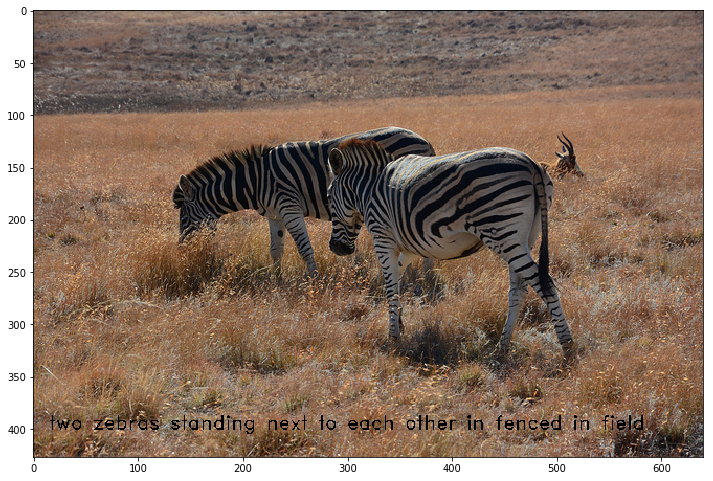

In [18]:
# Load the tokenizer
data_dir =  'D:/GoogleDrive/TechDocuments/Webinars/GrayAtom/Chapter_4_ImageCaptioning/ImageCaptionData/'
tokenizer = load(open(data_dir+'tokenizer.pkl', 'rb'))

# Define the max sequence length (from training)
max_length = 42

# Load the model
model = load_model(data_dir+'model-ep020-loss1.406.h5')

#load all features
all_features = load(open(data_dir+'features.pkl', 'rb'))

# Select an image and generate description for it
photo = all_features['COCO_val2014_000000353948']

# Generate description
description = generate_desc(model, tokenizer, photo, max_length)

#Import opencv library to load original image
import cv2

#Read Image
im = cv2.imread(data_dir+'COCO_val2014_000000353948.jpg')

#Put Description on the Image
description = description[8:-6]
im = cv2.putText(im,description,(5,400),cv2.FONT_HERSHEY_DUPLEX,0.6,(0,0,0))
im = im.astype("uint8")

# Write image into the directory
cv2.imwrite(data_dir+'COCO_val2014_000000353948_desc.jpg',im)

# Show Image
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

#Print description
print(description)

Great! Congratulations we have successfully created descriptions for our images. This is called success always comes with the hard work.

# Summary

I am still quite excited after what we learnt in this chapter. We had started from pretty simple theoretical example of multimodal learning in chapter 1, then we have tried to implement the multimodal algorithm for our beloved Gaussian distribution with a twist of two distribution in same dataset, we have understand the concept of information fusion to increase generalization of machine learning models, as you have learned we have successfully created class boundaries for our simple Gaussian distributions.

In chapter 2 we have seen what are visual features and how to extract them using a pre-trained model. We have successfully learned about image feature extraction using VGG architecture.

In chapter 3 we learned concepts about RNN. Then we move foreward with learning of LSTM and GRU networks. We had also generated text using LSTM network. Similar principle we had used in this chapter too.

Then we have dived into a fairly complex problem to understand the concepts of multimodal learning more deeply; image caption generation; and this problem gives us in depth understanding about multiple information sources, as you have seen we have discussed a lot of concepts from visual as well as textual domain, we have learned about VGG architecture in brief way, we seen how to work with LSTM units, and we have put quite serious effort to pre-process textual information, we have implemented various function for simplify our problem step by step,; at the end we have successfully implemented a working model of Image caption generation.

# Quiz

## Q1. Which of the following gives non-linearity to a neural network?

- A. Stochastic Gradient Descent
- B. Rectified Linear Unit
- C. Convolution function
- D. None of the above

Answer: (B) Rectified Linear unit is a non-linear activation function.

## Q2. Transfer learning is used for?

- A. Feature extraction from data.
- B. Transfer previous learned knowledge of network.
- C. Both A and B.
- D. None of the above.

Answer: (C) Transfer learning can be used for feature extraction as well as tranfer the previously learned knowledge to retrain a new network. 

## Q3. Tokenizer is used for?

- A. Creating sequence of words.
- B. Generating sparse representation of words.
- C. Maps words to integer.
- D. None of the above.

Answer: (C) Tokenizer is used to map words into integers.

## Q4. Word embedding is used for?

- A. Creating sequence of words.
- B. Generating sparse representation of words.
- C. Maps words to integer.
- D. None of the above.

Answer: (B) Word embedding layers are used to create sparse representation of words into vector space.

## Q5. Which of the following techniques perform similar operations as Dropout in a neural network?

- A. Bagging
- B. Boosting
- C. Stacking
- D. None of these

Answer: (A) Dropout can be seen as an extreme form of bagging in which each model is trained on a single case and each parameter of the model is very strongly regularized by sharing it with the corresponding parameter in all the other models.
